This notebook is used to for to train and build the model that our webapp will ultimately serve to users.

Import required libraries.

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import gradio as gr
import onnx

torch.set_float32_matmul_precision('high')

Define neural network architecture.

In [10]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()

        self.model = nn.Sequential(
            # Input size (1, 28, 28)
            # Convolutional Base
            # First convolution block
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 14, 14)
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 7, 7)

            # Linear head
            nn.Flatten(),
            # First linear block
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            # Second linear block
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

Setup pytorch lightning module for training the digit classifier.

In [11]:
class LitDigitClassifier(pl.LightningModule):
    def __init__(self):
        super(LitDigitClassifier, self).__init__()
        self.model = DigitClassifier()
        self.loss = nn.NLLLoss()
        self.train_losses = []
        self.test_losses = []
        self.epoch_train_accs = []
        self.epoch_test_accs = []
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc =  torchmetrics.Accuracy(task='multiclass', num_classes=10)
    
    def forward(self, x):
        return self.model(x)
    
    def on_fit_start(self):
        pl.seed_everything(42, workers=True) 
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = self.loss(y_pred, y)

        self.train_losses.append(loss.item())
        self.epoch_train_accs.append(self.train_acc(y_pred, y).item())
        
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = self.loss(y_pred, y)

        self.test_losses.append(loss.item())
        self.epoch_test_accs.append(self.test_acc(y_pred, y).item())

        self.log('val_loss', loss, logger=False)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

    def on_train_epoch_end(self):
        avg_train_loss = np.mean(self.train_losses)
        self.train_losses.clear()
        
        avg_train_acc = np.mean(self.epoch_train_accs)
        self.epoch_train_accs.clear()
        self.train_acc.reset()

        avg_test_loss = np.mean(self.test_losses)
        self.test_losses.clear()
        
        avg_test_acc = np.mean(self.epoch_test_accs)
        self.epoch_test_accs.clear()
        self.test_acc.reset()

        
        self.logger.experiment.add_scalars('loss', { 'train': avg_train_loss, 'test': avg_test_loss }, self.current_epoch)
        self.logger.experiment.add_scalars('accuracy', { 'train': avg_train_acc, 'test': avg_test_acc }, self.current_epoch)

    def on_test_epoch_end(self):
        avg_loss = np.mean(self.test_losses)
        self.test_losses.clear()
        
        avg_acc = np.mean(self.epoch_test_accs)
        self.epoch_test_accs.clear()
        self.test_acc.reset()

        self.logger.experiment.add_scalars('loss', { 'test': avg_loss }, self.current_epoch)
        self.logger.experiment.add_scalars('accuracy', { 'test': avg_acc }, self.current_epoch)


In [12]:
# # Create a new instance of your model architecture
# model = LitDigitClassifier()

# try:
#     # Load the state_dict from the file
#     model.model.load_state_dict(torch.load('model_weights.pth'))
# except:
#     print('Unable to load previous model')

# # Set the model to evaluation mode
# model.model.eval()

Load MNIST dataset

In [13]:
class InvertImage(object):
    def __call__(self, x):
        return 1 - x

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

inv_minst_transform = transforms.Compose([
    transforms.ToTensor(),
    InvertImage(),
    transforms.Normalize((0.1307,), (0.3081,))
])

spatial_mnist_transform = transforms.Compose([
    # transforms.RandomRotation(degrees=15), # rotation can cause some weird issues
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.9, 1.1)),
    mnist_transform
])

inv_spatial_mnist_transform = transforms.Compose([
    # transforms.RandomRotation(degrees=15), # rotation can cause some weird issues
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.9, 1.1)),
    inv_minst_transform
])

original_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=mnist_transform
)
inv_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=inv_minst_transform
)
spatial_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=spatial_mnist_transform
)
inv_spatial_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=inv_spatial_mnist_transform
)

train_dataset = ConcatDataset([original_train_dataset, inv_train_dataset, spatial_train_dataset, inv_spatial_train_dataset])

original_test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=mnist_transform
)

inv_test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=inv_minst_transform
)

test_dataset = ConcatDataset([original_test_dataset, inv_test_dataset])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

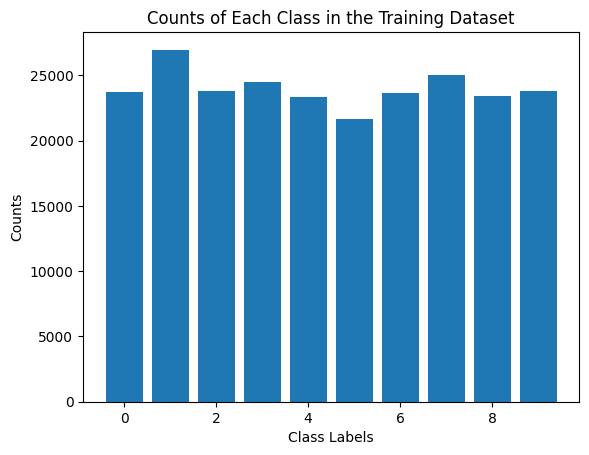

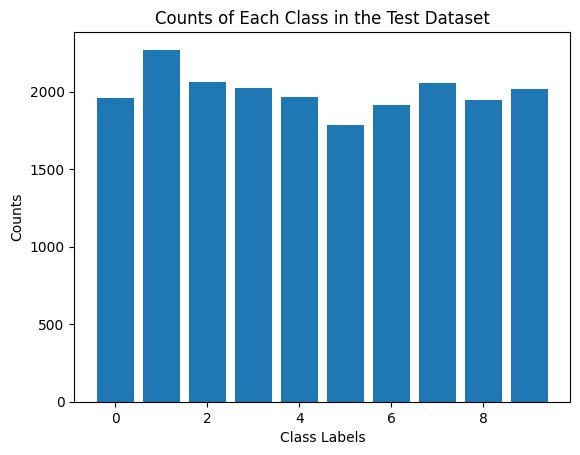

In [14]:
# Count occurrences of each class
class_counts = np.zeros(10)
for _, label in train_dataset:
    class_counts[label] += 1

# Create a bar graph
class_labels = np.arange(10)
plt.bar(class_labels, class_counts)

plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Counts of Each Class in the Training Dataset')

plt.show()

# Count occurrences of each class
class_counts = np.zeros(10)
for _, label in test_dataset:
    class_counts[label] += 1

# Create a bar graph
class_labels = np.arange(10)
plt.bar(class_labels, class_counts)

plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Counts of Each Class in the Test Dataset')

plt.show()

Preview some of the training samples.

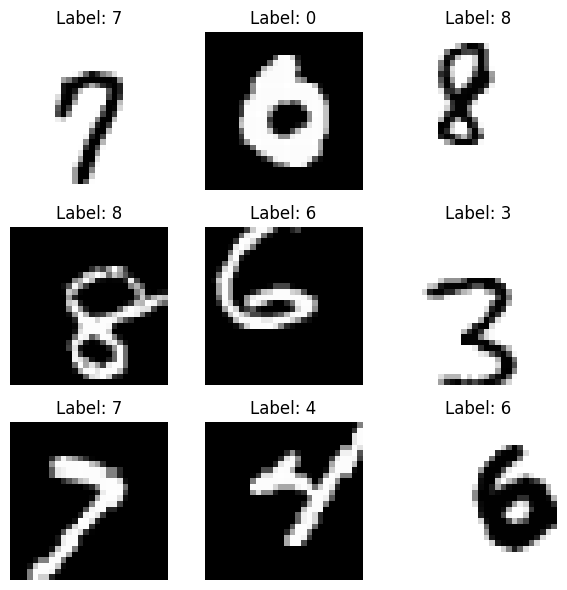

In [15]:
# Function to unnormalize and convert tensor to a PIL image
def unnormalize(tensor):
    mean = 0.1307
    std = 0.3081
    img = tensor.clone().detach().numpy()
    img = (img * std) + mean
    img = img.squeeze()
    return img

# Display a grid of sample images
num_samples = 9
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    idx = torch.randint(0, len(train_dataset), (1,)).item()
    img, label = train_dataset[idx]
    img_unnorm = unnormalize(img)
    ax.imshow(img_unnorm, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Train and test the model, then plot the train and test losses per epoch.

In [16]:
model = LitDigitClassifier()
logger = TensorBoardLogger('lightning_logs', name='mnist')
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=True)
trainer = pl.Trainer(
    max_epochs=200,
    min_epochs=3,
    precision='32',
    devices=torch.cuda.device_count(),
    accelerator="gpu",
    logger=logger,
    callbacks=[early_stop_callback]
)
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | DigitClassifier    | 454 K 
1 | loss      | NLLLoss            | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
454 K     Trainable params
0         Non-trainable params
454 K     Total params
1.818     Total estimated model params size (MB)
Global seed set to 42


Epoch 0: 100%|██████████| 7500/7500 [00:55<00:00, 135.90it/s, v_num=27]     

Metric val_loss improved. New best score: 0.066


Epoch 1: 100%|██████████| 7500/7500 [00:55<00:00, 134.11it/s, v_num=27]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.041


Epoch 2: 100%|██████████| 7500/7500 [00:55<00:00, 134.53it/s, v_num=27]

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.032


Epoch 3: 100%|██████████| 7500/7500 [00:55<00:00, 135.48it/s, v_num=27]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.029


Epoch 4: 100%|██████████| 7500/7500 [00:56<00:00, 133.20it/s, v_num=27]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.026


Epoch 5: 100%|██████████| 7500/7500 [00:55<00:00, 134.80it/s, v_num=27]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.023


Epoch 8: 100%|██████████| 7500/7500 [00:55<00:00, 136.22it/s, v_num=27]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.021


Epoch 9: 100%|██████████| 7500/7500 [00:55<00:00, 134.86it/s, v_num=27]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020


Epoch 12: 100%|██████████| 7500/7500 [00:55<00:00, 135.19it/s, v_num=27]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.019


Epoch 17: 100%|██████████| 7500/7500 [00:57<00:00, 129.81it/s, v_num=27]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.019. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 7500/7500 [00:57<00:00, 129.78it/s, v_num=27]


In [24]:
torch.save(model.model.state_dict(), 'model_weights.pth')

In [25]:
# Create a new instance of your model architecture
digitClassifier = DigitClassifier()

# Load the state_dict from the file
digitClassifier.load_state_dict(torch.load('model_weights.pth'))

# Set the model to evaluation mode
digitClassifier.eval()

DigitClassifier(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
    (11): LogSoftmax(dim=1)
  )
)

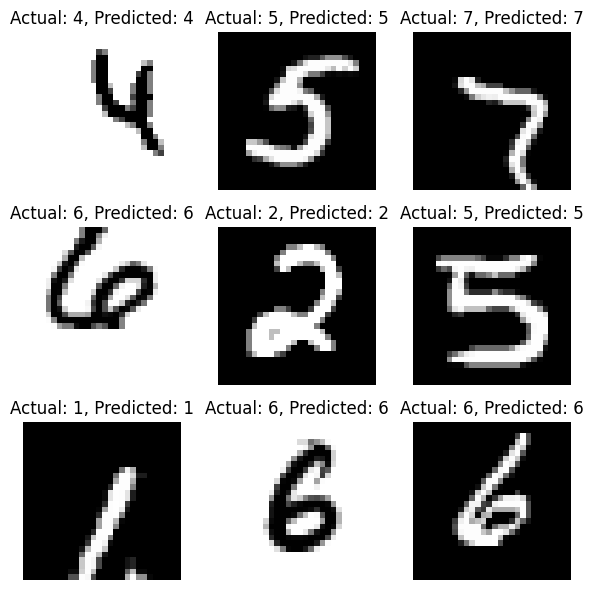

In [26]:
# Function to unnormalize and convert tensor to a PIL image
def unnormalize(tensor):
    mean = 0.1307
    std = 0.3081
    img = tensor.clone().detach().numpy()
    img = (img * std) + mean
    img = img.squeeze()
    return img

# Display a grid of sample images
num_samples = 9
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

digitClassifier.eval()
for i, ax in enumerate(axes.ravel()):
    idx = torch.randint(0, len(train_dataset), (1,)).item()
    img, label = train_dataset[idx]
    img_unnorm = unnormalize(img)
    with torch.no_grad():
        prediction = torch.exp(digitClassifier(img.unsqueeze(0)))
        predicted_label = torch.argmax(prediction, dim=1).item()
    ax.imshow(img_unnorm, cmap='gray')
    ax.set_title(f'Actual: {label}, Predicted: {predicted_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Experiment with gradio interface.

In [28]:
def classify(image):
    if image is None:
        return {str(i): 0 for i in range(10)}
    
    digitClassifier.eval()
    with torch.no_grad():
        X = transforms.ToTensor()(image).unsqueeze(0)
        y = torch.exp(digitClassifier(X)).tolist()[0]
        confidences = {str(i): y[i] for i in range(10)}
    return confidences
    
sketchpad = gr.Sketchpad(shape=(28, 28), invert_colors=False)
label = gr.components.Label(num_top_classes=3)
interface = gr.Interface(classify, sketchpad, label, live=True)

In [29]:
interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Finally, export our trained model via ONNX to our webapps `asset` folder.

In [30]:
dummy_input = torch.randn(1, 1, 28, 28)
digitClassifier.eval()

# Export the model
torch.onnx.export(
    digitClassifier,                        # model being run
    # model input (or a tuple for multiple inputs)
    dummy_input,
    # where to save the model (can be a file or file-like object)
    "src/assets/mnist.onnx",
    input_names = ['input'],     # the model's input names
    output_names = ['output'],    # the model's output names
    dynamic_axes = {
        # variable length axes
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    verbose=True,
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [31]:
# Load the ONNX model
onnx_model = onnx.load("src/assets/mnist.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input[FLOAT, batch_sizex1x28x28]
) initializers (
  %model.0.weight[FLOAT, 32x1x3x3]
  %model.0.bias[FLOAT, 32]
  %model.3.weight[FLOAT, 64x32x5x5]
  %model.3.bias[FLOAT, 64]
  %model.7.weight[FLOAT, 128x3136]
  %model.7.bias[FLOAT, 128]
  %model.10.weight[FLOAT, 10x128]
  %model.10.bias[FLOAT, 10]
) {
  %/model/model.0/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%input, %model.0.weight, %model.0.bias)
  %/model/model.1/Relu_output_0 = Relu(%/model/model.0/Conv_output_0)
  %/model/model.2/MaxPool_output_0 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%/model/model.1/Relu_output_0)
  %/model/model.3/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%/model/model.2/MaxPool_output_0, %model.3.weight, %model.3.bias)
  %/model/model.4/Relu_output_0 = Relu(%/model/model.3/Conv_output_0)
  %/model/mo